In [35]:
from langgraph.graph import END, START, StateGraph
from typing import TypedDict, Optional
import subprocess
from openai import OpenAI
import vertexai
from langgraph.types import Send, interrupt, Command
import textwrap
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated
import operator
from IPython.display import Image, display
import base64
from vertexai.preview.vision_models import ImageGenerationModel
import os
from langgraph.checkpoint.memory import InMemorySaver
import time

memory = InMemorySaver()

llm = init_chat_model("openai:gpt-4o-mini")
PROJECT_ID = "gen-lang-client-0985459382" 
LOCATION = "us-central1"

print(f"🔄 Initializing Vertex AI for project: {PROJECT_ID}...")
try:
    vertexai.init(project=PROJECT_ID, location=LOCATION)
    print("✅ Vertex AI Initialized Successfully!")
except Exception as e:
    print(f"⚠️ Vertex AI Init Warning: {e}")
    print("-> 'gcloud auth application-default login'이 제대로 되었는지 확인해주세요.")

class State(TypedDict):
    video_file: Optional[str]
    script_file: Optional[str]
    audio_file: Optional[str]
    transcription: str
    summaries: Annotated[list[str], operator.add]
    thumbnail_prompts: Annotated[list[str], operator.add]
    thumbnail_sketches: Annotated[list[str], operator.add]
    final_summary: str
    user_feedback: str
    chosen_prompt: str

def extract_audio(state: State):
    output_file = state["video_file"].replace("mp4", "mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        "-y",
        output_file,
    ]
    subprocess.run(command)
    return {
        "audio_file": output_file,
    }

def transcribe_audio(state: State):
    client = OpenAI()
    with open(state["audio_file"], "rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio_file,
            language="ko",
        )
        return {
            "transcription": transcription,
        }

def load_scripts(state: State):
    with open(state["script_file"], "r", encoding="utf-8") as f:
        text = f.read()
    return {
        "transcription": text
        }

def route_input(state: State):
    if state["script_file"]:
        return "load_scripts"
    return "extract_audio"

def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({"id": i + 1, "chunk": chunk})
    return [Send("summarize_chunk", chunk) for chunk in chunks]


def summarize_chunk(chunk):
    chunk_id = chunk["id"]
    chunk = chunk["chunk"]

    response = llm.invoke(
        f"""
        Please summarize the following text.

        Text: {chunk}
        """
    )
    summary = f"[Chunk {chunk_id}] {response.content}"
    return {
        "summaries": [summary],
    }

def mega_summary(state: State):
    all_summaries = "\n".join(state["summaries"])
    prompt = f"""
        You are given multiple summaries of different chunks from a video transcription.
        Please create a comprehensive final summary that combines all the key points.
        Individual summaries:
        {all_summaries}
    """
    response = llm.invoke(prompt)
    return {
        "final_summary": response.content,
    }


def dispatch_artists(state: State):
    return [
        Send(
            "generate_thumbnails",
            {
                "id": i,
                "summary": state["final_summary"],
            },
        )
        for i in [1, 2, 3]
    ]


def generate_thumbnails_sequential(state: State):
    """
    [수정됨] 할당량(Quota) 이슈 방지를 위해 3장을 순차적으로 생성합니다.
    """
    summary = state["final_summary"]
    generated_files = []
    generated_prompts = []
    
    # Imagen 3 모델 로드
    try:
        model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")
    except Exception as e:
        print(f"❌ Model Load Error: {e}")
        return {"thumbnail_sketches": []}

    print("🎨 Starting Sequential Image Generation (Quota Friendly)...")

    for concept_id in [1, 2, 3]:
        # 1. 프롬프트 작성
        prompt_design = f"""
        Create a prompt for Google Imagen 3 to generate a YouTube thumbnail.
        Concept #{concept_id}: Make it distinct. High quality, photorealistic.
        Output ONLY the English prompt text.
        Summary: {summary}
        """
        prompt_response = llm.invoke(prompt_design)
        imagen_prompt = prompt_response.content
        generated_prompts.append(imagen_prompt)
        print(f"   Generating Image {concept_id}/3...")

        try:
            # 2. 이미지 생성
            images = model.generate_images(
                prompt=imagen_prompt,
                number_of_images=1,
                aspect_ratio="16:9",
                safety_filter_level="block_only_high",
                person_generation="allow_adult",
            )
            
            # 3. 저장
            filename = f"thumbnail_concept_{concept_id}.png"
            images[0].save(location=filename, include_generation_parameters=False)
            generated_files.append(filename)
            print(f"   ✅ Saved: {filename}")
            
            # [핵심] 할당량(Quota) 초과 방지를 위한 대기
            if concept_id < 3: # 마지막 이미지가 아니면 대기
                print("   ⏳ Cooling down for 60s (Google Quota Limit)...")
                time.sleep(60)

        except Exception as e:
            print(f"   ❌ Failed {concept_id}: {e}")
            # 할당량 에러 발생 시 잠시 대기 로직을 넣을 수도 있으나, 
            # 순차 실행만으로도 보통 해결됩니다.
            if len(generated_prompts) > len(generated_files):
                 generated_files.append("error_placeholder.png")
    
    return {"thumbnail_sketches": generated_files, "thumbnail_prompts": generated_prompts}

def human_feedback(state: State):
    answer = interrupt(
        {
            "chosen_thumbnail": "Which thumbnail do you like the most?",
            "feedback": "Provide any feedback or changes you'd like for the final thumbnail.",
        }
    )
    user_feedback = answer["user_feedback"]
    chosen_prompt = answer["chosen_prompt"]
    return {
        "user_feedback": user_feedback,
        "chosen_prompt": state["thumbnail_prompts"][chosen_prompt - 1],
    }


def generate_hd_thumbnail(state: State):

    chosen_prompt = state["chosen_prompt"]
    user_feedback = state["user_feedback"]

    prompt = f"""
    You are a professional YouTube thumbnail designer. Take this original thumbnail prompt and create an enhanced version that incorporates the user's specific feedback.

    ORIGINAL PROMPT:
    {chosen_prompt}

    USER FEEDBACK TO INCORPORATE:
    {user_feedback}

    Create an enhanced prompt that:
        1. Maintains the core concept from the original prompt
        2. Specifically addresses and implements the user's feedback requests
        3. Adds professional YouTube thumbnail specifications:
            - High contrast and bold visual elements
            - Clear focal points that draw the eye
            - Professional lighting and composition
            - Optimal text placement and readability with generous padding from edges
            - Colors that pop and grab attention
            - Elements that work well at small thumbnail sizes
            - IMPORTANT: Always ensure adequate white space/padding between any text and the image borders
    """

    response = llm.invoke(prompt)

    final_thumbnail_prompt = response.content
    enhanced_prompt = f"{final_thumbnail_prompt}, 8k resolution, photorealistic, masterpiece, highly detailed, sharp focus"
    
    try:
        model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")
    except Exception as e:
        print(f"❌ Model Load Error: {e}")
        return {"thumbnail_final": []}

    try:
        # 2. 이미지 생성
        images = model.generate_images(
            prompt=enhanced_prompt,
            number_of_images=1,
            aspect_ratio="16:9",
            safety_filter_level="block_only_high",
            person_generation="allow_adult",
        )
        filename = "thumbnail_final.png"
        images[0].save(location=filename, include_generation_parameters=False)
        print(f"✅ Final Thumbnail Saved: {filename}")
        
        return {
            "thumbnail_final": filename, # 파일 경로 반환 (str)
        }
        
    except Exception as e:
        print(f"❌ Final Image Generation Error: {e}")
        return {"thumbnail_final": "error"}

🔄 Initializing Vertex AI for project: gen-lang-client-0985459382...
✅ Vertex AI Initialized Successfully!


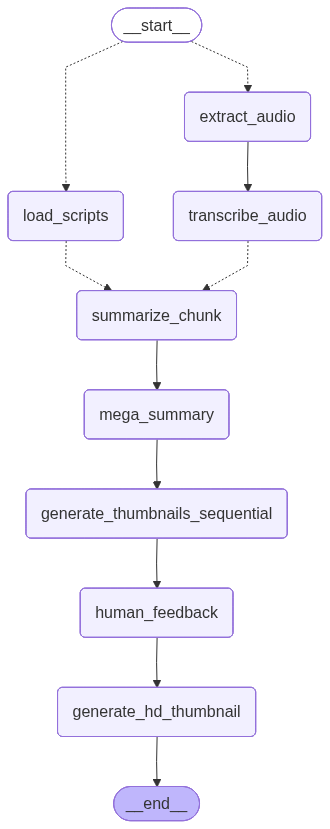

In [36]:
graph_builder = StateGraph(State)

graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)
graph_builder.add_node("load_scripts", load_scripts)
graph_builder.add_node("summarize_chunk", summarize_chunk)
graph_builder.add_node("mega_summary", mega_summary)
graph_builder.add_node("generate_thumbnails_sequential", generate_thumbnails_sequential)

graph_builder.add_node("human_feedback", human_feedback)
graph_builder.add_node("generate_hd_thumbnail", generate_hd_thumbnail)

graph_builder.add_conditional_edges(
    START,
    route_input,
    {
        "extract_audio": "extract_audio",
        "load_scripts": "load_scripts",
    }
)

graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_conditional_edges(
    "transcribe_audio", dispatch_summarizers, ["summarize_chunk"]
)

graph_builder.add_conditional_edges(
    "load_scripts", 
    dispatch_summarizers, 
    ["summarize_chunk"]
)

graph_builder.add_edge("summarize_chunk", "mega_summary")
graph_builder.add_edge("mega_summary", "generate_thumbnails_sequential")
graph_builder.add_edge("generate_thumbnails_sequential", "human_feedback")
graph_builder.add_edge("human_feedback", "generate_hd_thumbnail")
graph_builder.add_edge("generate_hd_thumbnail", END)

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
config = {
    "configurable": {
        "thread_id": "4",
    },
}

In [38]:
graph.invoke(
    {"script_file": "scripts.md"},
    config=config,
)

🎨 Starting Sequential Image Generation (Quota Friendly)...
   Generating Image 1/3...
   ✅ Saved: thumbnail_concept_1.png
   ⏳ Cooling down for 60s (Google Quota Limit)...
   Generating Image 2/3...
   ✅ Saved: thumbnail_concept_2.png
   ⏳ Cooling down for 60s (Google Quota Limit)...
   Generating Image 3/3...
   ✅ Saved: thumbnail_concept_3.png


{'script_file': 'scripts.md',
 'transcription': '뭔가 신기하지 않아요? 이 모든 게 현실이라는 게. 무슨 뜻이냐면, 그렇게 생각하지 않으세요? 이 모든 AI 관련 내용과 실리콘밸리 이야기가 현실이라는 게요.\n정말 공상 과학 소설 같지 않나요? 또 신기한 건 서서히 발전하는 게 당연하게 느껴진다는 거예요.\nAI에 GDP의 1%를 투자한다는 아이디어는 훨씬 더 큰일처럼 느껴졌을 텐데, 지금은 그냥 그런가 보다 하게 되는 것 같아요.\n우리는 꽤 빨리 익숙해지는 것 같아요. 하지만 추상적이기도 해요. 그게 무슨 의미일까요?\n뉴스에서 어느 회사가 얼마를 투자했다고 발표하는 것만 보게 되죠. 그게 전부예요. 아직까지는 다른 방식으로 체감되지는 않아요.\n여기서부터 시작해야 할까요? 흥미로운 논의가 될 것 같아요. 좋아요. 평균적인 사람의 관점에서는 별로 달라진 게 없다는 점이 특이점까지도 계속될 거라는 당신의 의견이 흥미롭네요.\n아뇨, 그렇게 생각하지 않아요. 알겠습니다. 제가 다르게 느껴지지 않는다고 말한 것은, 어느 회사가 이해하기 어려운 엄청난 금액의 투자를 발표했다는 거예요.\n아무도 그걸 어떻게 해야 할지 모르는 것 같아요.\n하지만 AI의 영향은 체감될 거라고 생각해요. AI는 경제 전반으로 확산될 거예요.\n이를 뒷받침하는 강력한 경제적 힘이 있을 것이고, 그 영향은 매우 강하게 느껴질 것이라고 생각합니다. 그 영향이 언제쯤 나타날 거라고 예상하시나요?\n모델은 경제적 영향에 비해 더 똑똑해 보여요. 네. 지금 모델에 대해 매우 혼란스러운 점 중 하나죠.\n평가에서 모델이 그렇게 잘하는 것을 어떻게 설명해야 할까요? 평가를 보면 \'꽤 어려운 평가인데\'라고 생각하게 되죠. 모델이 정말 잘하고 있어요.\n하지만 경제적 영향은 훨씬 뒤처지는 것 같아요. 모델이 한편으로는 놀라운 일들을 해내면서, 다른 한편으로는 특정 상황에서 같은 말을 두 번 반복하는 이유를 이해하기가 매우 어렵습니다.\n예를 들어, 바이브 코딩

In [39]:
response = {
    "user_feedback": "remove any uncertain words, or any logo, and give it not ai engined photos",
    "chosen_prompt": 1,
}

graph.invoke(
    Command(resume=response),
    config=config,
)

✅ Final Thumbnail Saved: thumbnail_final.png


{'script_file': 'scripts.md',
 'transcription': '뭔가 신기하지 않아요? 이 모든 게 현실이라는 게. 무슨 뜻이냐면, 그렇게 생각하지 않으세요? 이 모든 AI 관련 내용과 실리콘밸리 이야기가 현실이라는 게요.\n정말 공상 과학 소설 같지 않나요? 또 신기한 건 서서히 발전하는 게 당연하게 느껴진다는 거예요.\nAI에 GDP의 1%를 투자한다는 아이디어는 훨씬 더 큰일처럼 느껴졌을 텐데, 지금은 그냥 그런가 보다 하게 되는 것 같아요.\n우리는 꽤 빨리 익숙해지는 것 같아요. 하지만 추상적이기도 해요. 그게 무슨 의미일까요?\n뉴스에서 어느 회사가 얼마를 투자했다고 발표하는 것만 보게 되죠. 그게 전부예요. 아직까지는 다른 방식으로 체감되지는 않아요.\n여기서부터 시작해야 할까요? 흥미로운 논의가 될 것 같아요. 좋아요. 평균적인 사람의 관점에서는 별로 달라진 게 없다는 점이 특이점까지도 계속될 거라는 당신의 의견이 흥미롭네요.\n아뇨, 그렇게 생각하지 않아요. 알겠습니다. 제가 다르게 느껴지지 않는다고 말한 것은, 어느 회사가 이해하기 어려운 엄청난 금액의 투자를 발표했다는 거예요.\n아무도 그걸 어떻게 해야 할지 모르는 것 같아요.\n하지만 AI의 영향은 체감될 거라고 생각해요. AI는 경제 전반으로 확산될 거예요.\n이를 뒷받침하는 강력한 경제적 힘이 있을 것이고, 그 영향은 매우 강하게 느껴질 것이라고 생각합니다. 그 영향이 언제쯤 나타날 거라고 예상하시나요?\n모델은 경제적 영향에 비해 더 똑똑해 보여요. 네. 지금 모델에 대해 매우 혼란스러운 점 중 하나죠.\n평가에서 모델이 그렇게 잘하는 것을 어떻게 설명해야 할까요? 평가를 보면 \'꽤 어려운 평가인데\'라고 생각하게 되죠. 모델이 정말 잘하고 있어요.\n하지만 경제적 영향은 훨씬 뒤처지는 것 같아요. 모델이 한편으로는 놀라운 일들을 해내면서, 다른 한편으로는 특정 상황에서 같은 말을 두 번 반복하는 이유를 이해하기가 매우 어렵습니다.\n예를 들어, 바이브 코딩